# Benchmarking a TCR Beta embedder model

## Setup

In [169]:
import os
from pathlib import Path
import sys

if '__project_dir__' not in globals():
    __project_dir__ = Path.cwd().parents[1].resolve()

sys.path.append(__project_dir__)
os.chdir(__project_dir__)

In [170]:
import json
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
from pathlib import Path
import seaborn
from sklearn.decomposition import PCA
from src.datahandling.dataloaders import TCRDataLoader
from src.datahandling.datasets import TCRDataset
from src.datahandling import tokenisers
from src import models
from src import metrics
import torch
from tqdm import tqdm

seaborn.set_theme()
seaborn.set_style('white')

In [171]:
if torch.cuda.is_available():
    device = torch.device('cuda:0')
else:
    device = torch.device('cpu')

### Load model

In [172]:
SAVE_DIR = Path('/home/yutanagano/UCLOneDrive/MBPhD/projects/tcr_embedder/model_saves/')
MODEL_DIR = SAVE_DIR/'BCDRBERT_+ACL_cns_020'

with open(MODEL_DIR/'config.json', 'r') as f:
    config = json.load(f)

model = getattr(models, config['model']['class'])(
    **config['model']['config']
)
model.load_state_dict(torch.load(MODEL_DIR/'state_dict.pt'))
model.eval()
model.to(device)

# model = modules.AtchleyEmbedder()
# model.to(device)

BCDRClsBERT(
  (encoder_stack): TransformerEncoder(
    (layers): ModuleList(
      (0): TransformerEncoderLayer(
        (self_attn): MultiheadAttention(
          (out_proj): NonDynamicallyQuantizableLinear(in_features=128, out_features=128, bias=True)
        )
        (linear1): Linear(in_features=128, out_features=512, bias=True)
        (dropout): Dropout(p=0.1, inplace=False)
        (linear2): Linear(in_features=512, out_features=128, bias=True)
        (norm1): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
        (norm2): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
        (dropout1): Dropout(p=0.1, inplace=False)
        (dropout2): Dropout(p=0.1, inplace=False)
      )
      (1): TransformerEncoderLayer(
        (self_attn): MultiheadAttention(
          (out_proj): NonDynamicallyQuantizableLinear(in_features=128, out_features=128, bias=True)
        )
        (linear1): Linear(in_features=128, out_features=512, bias=True)
        (dropout): Dropout(p=0.1,

### Load training log

In [173]:
training_log = pd.read_csv(MODEL_DIR/'log.csv')

### Create benchmarking directory

In [174]:
BENCHMARK_DIR = Path(f'benchmarks_beta/{model.name}')
if not BENCHMARK_DIR.is_dir():
    BENCHMARK_DIR.mkdir()

### Create cache directory

In [175]:
CACHE_DIR = BENCHMARK_DIR/'.cache'
if not CACHE_DIR.is_dir():
    CACHE_DIR.mkdir()

### Load data

In [176]:
back_df = pd.read_csv('/home/yutanagano/UCLOneDrive/MBPhD/projects/tcr_embedder/data/preprocessed/tanno/test.csv')
back_df[['TRAV','CDR3A','TRAJ']] = pd.NA
back_ds = TCRDataset(
    data=back_df,
    tokeniser=getattr(tokenisers, config['data']['tokeniser']['class'])(
        **config['data']['tokeniser']['config']
    )
)
back_dl = TCRDataLoader(dataset=back_ds, batch_size=512, shuffle=False)

In [177]:
ep_df = pd.read_csv('/home/yutanagano/UCLOneDrive/MBPhD/projects/tcr_embedder/data/preprocessed/vdjdb/evaluation_beta.csv')
ep_df[['TRAV','CDR3A','TRAJ']] = pd.NA
ep_ds = TCRDataset(
    data=ep_df,
    tokeniser=getattr(tokenisers, config['data']['tokeniser']['class'])(
        **config['data']['tokeniser']['config']
    )
)
ep_dl = TCRDataLoader(dataset=ep_ds, batch_size=512, shuffle=False)

## Record training log stats and generate plots for them

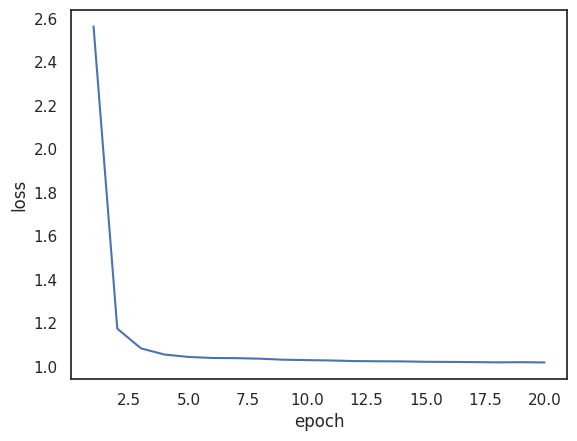

In [178]:
seaborn.lineplot(training_log, x='epoch', y='loss')
plt.savefig(BENCHMARK_DIR/'loss.png')

## Use model to embed TCRs

In [179]:
SAVED_BACK_EMBS = (CACHE_DIR/'back_embs.pt').is_file()
SAVED_EP_EMBS = (CACHE_DIR/'ep_embs.pt').is_file()

In [180]:
if not SAVED_BACK_EMBS:
    with torch.no_grad():
        back_embs = [model.embed(x.to(device)) for x in tqdm(back_dl)]
        back_embs = torch.concat(back_embs)

    torch.save(back_embs.cpu(), CACHE_DIR/'back_embs.pt')

else:
    back_embs = torch.load(CACHE_DIR/'back_embs.pt').to(device)

100%|██████████| 160/160 [00:13<00:00, 11.56it/s]


In [181]:
if not SAVED_EP_EMBS:
    with torch.no_grad():
        ep_embs = [model.embed(x.to(device)) for x in tqdm(ep_dl)]
        ep_embs = torch.concat(ep_embs)

    torch.save(ep_embs.cpu(), CACHE_DIR/'ep_embs.pt')

else:
    ep_embs = torch.load(CACHE_DIR/'ep_embs.pt').to(device)

100%|██████████| 6/6 [00:00<00:00, 11.73it/s]


## Fit a PCA to the background TCR (Tanno et al.) data

In [182]:
pca = PCA()
pca.fit(back_embs.cpu().detach().numpy())

PCA()

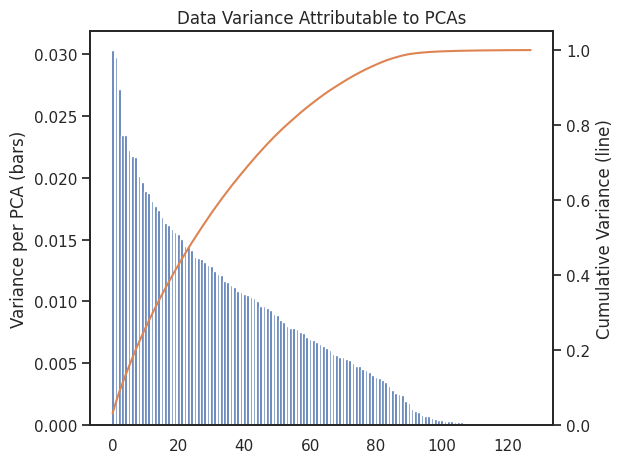

In [183]:
# Display ratios of variance explained by each of the PCAs
cumulative_variance = np.cumsum(pca.explained_variance_ratio_)

pca_summary = plt.figure()

ax = plt.axes()
ax.set_title('Data Variance Attributable to PCAs')
ax.set_ylabel('Variance per PCA (bars)')

axd = ax.twinx()
axd.set_ylabel('Cumulative Variance (line)')
axd.set_ylim(0,1.05)

ax.bar(range(pca.n_components_), pca.explained_variance_ratio_)
axd.plot(cumulative_variance, c='C1')

plt.tight_layout()
plt.savefig(BENCHMARK_DIR/'pca.png')
plt.show()

### Visualise TCR distribution in embedding space

In [184]:
background = pca.transform(back_embs.cpu().detach().numpy())[:,:2]
epitope_labeled = pca.transform(ep_embs.cpu().detach().numpy())[:,:2]

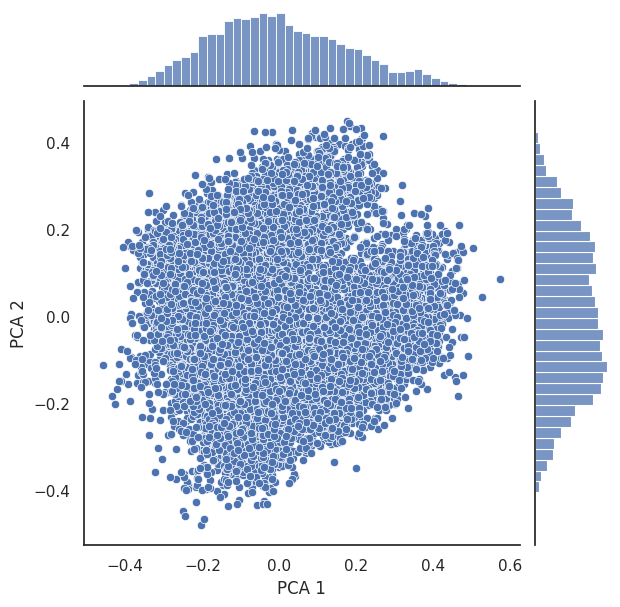

In [185]:
bg_viz = seaborn.jointplot(x=background[:10000,0], y=background[:10000,1])

ylim = bg_viz.ax_joint.get_ylim()
xlim = bg_viz.ax_joint.get_xlim()

bg_viz.set_axis_labels(xlabel='PCA 1', ylabel='PCA 2')
bg_viz.savefig(BENCHMARK_DIR/'bg_viz.png')
plt.show()

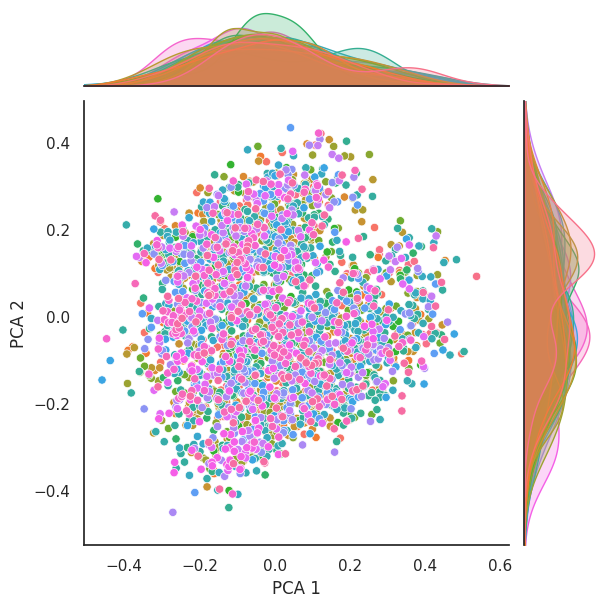

In [186]:
ep_viz = seaborn.jointplot(x=epitope_labeled[:10000,0], y=epitope_labeled[:10000,1], xlim=xlim, ylim=ylim, hue=ep_ds._data['Epitope'].iloc[:10000], legend=False)
ep_viz.set_axis_labels(xlabel='PCA 1', ylabel='PCA 2')
ep_viz.savefig(BENCHMARK_DIR/'ep_viz.png')
plt.show()

## Calculate alignment and uniformity

In [187]:
epitope_cat_codes = torch.tensor(ep_ds._data['Epitope'].astype('category').cat.codes).to(device)

In [188]:
alignment = metrics.alignment(ep_embs, epitope_cat_codes).item()

In [189]:
uniformity = metrics.uniformity(ep_embs).item()

## k-NN evaluation

In [190]:
NUM_EPITOPES = ep_ds._data['Epitope'].nunique()
EPGRP_SIZE = ep_ds._data.groupby('Epitope').size().iloc[0]

In [191]:
if (CACHE_DIR/'ep_cdist.pt').is_file():
    ep_cdist = torch.load(CACHE_DIR/'ep_cdist.pt').to(device)
else:
    ep_cdist = torch.cdist(ep_embs, ep_embs, p=2)
    torch.save(ep_cdist.cpu(), CACHE_DIR/'ep_cdist.pt')

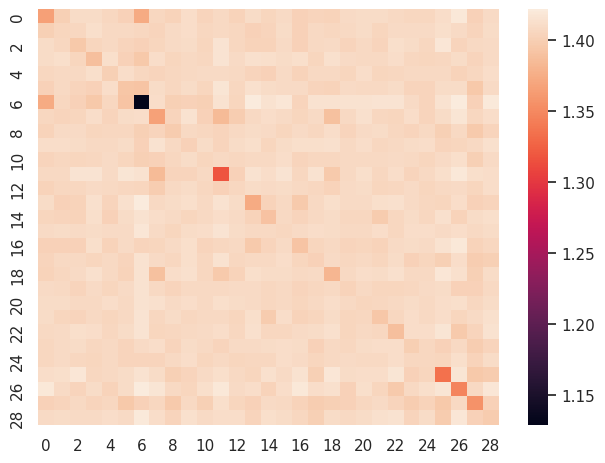

In [192]:
avg_dist_in_group = torch.nn.functional.avg_pool2d(ep_cdist.unsqueeze(0),EPGRP_SIZE).squeeze(0)
scaling_factor = torch.ones(NUM_EPITOPES,NUM_EPITOPES).fill_diagonal_(EPGRP_SIZE/(EPGRP_SIZE-1)).to(device)
avg_dist_in_group *= scaling_factor

c_dist_map = seaborn.heatmap(avg_dist_in_group.cpu())
plt.tight_layout()
plt.savefig(BENCHMARK_DIR/'cdists.png')
plt.show()

In [193]:
ep_cdist.fill_diagonal_(torch.inf)

tensor([[   inf, 1.3510, 1.3416,  ..., 1.3211, 1.1526, 1.4758],
        [1.3510,    inf, 1.2689,  ..., 1.4350, 1.4203, 1.4076],
        [1.3416, 1.2689,    inf,  ..., 1.5287, 1.5457, 1.5258],
        ...,
        [1.3211, 1.4350, 1.5287,  ...,    inf, 1.2913, 1.4862],
        [1.1526, 1.4203, 1.5457,  ..., 1.2913,    inf, 1.4307],
        [1.4758, 1.4076, 1.5258,  ..., 1.4862, 1.4307,    inf]],
       device='cuda:0')

In [194]:
knn_scores = dict()

for k in (5, 10, 50, 100):
    scores = []
    ep_size = len(ep_embs)

    for tcr_index in tqdm(range(ep_size)):
        # Get correct epitope label
        expected = epitope_cat_codes[tcr_index]

        # Get list of distances for that TCR
        dists = ep_cdist[tcr_index]

        # Get indices of nearest neighbours
        _, idcs = torch.topk(dists, k=k, largest=False)

        # Get epitopes of nearest neighbours
        knn_cat_codes = epitope_cat_codes[idcs]

        # Predict epitope
        pred, _ = torch.mode(knn_cat_codes)

        # Record score
        scores.append(expected.item() == pred.item())

    score = torch.tensor(scores, dtype=torch.float32).mean().item()

    print(f'{k}-NN score: {score}')

    knn_scores[k] = score

100%|██████████| 2900/2900 [00:00<00:00, 12524.05it/s]


5-NN score: 0.2524137794971466


100%|██████████| 2900/2900 [00:00<00:00, 12589.58it/s]


10-NN score: 0.25413793325424194


100%|██████████| 2900/2900 [00:00<00:00, 12351.57it/s]


50-NN score: 0.23379310965538025


100%|██████████| 2900/2900 [00:00<00:00, 11694.35it/s]

100-NN score: 0.21068964898586273


## Write out evaluation metrics to json

In [195]:
metrics_dict = {
    'model_name': model.name,
    'alignment': alignment,
    'uniformity': uniformity,
    'knn_scores': knn_scores
}

In [196]:
with open(BENCHMARK_DIR/'metrics.json', 'w') as f:
    json.dump(metrics_dict, f, indent=4)